### Imports

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statistics
import math
import pandas as pd
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit
from scipy.integrate import simps
from matplotlib import cm,rc
import sys 
path_project = '/home/danshach/pot_store/gpfs_scratch/Xalantir'
sys.path.insert(1, path_project)
from cycler import cycler
from matplotlib import patches
from glob import glob
import re
import json
import copy

### Plot Format

In [3]:

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }
my_width = jour_sizes["PRD"]["twocol"]
#my_width = jour_sizes[""]

# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2
plt.style.use("thesis.mplstyle")
#plt.style.use('ggplot')

### Diverse& Helper Functions

In [4]:
def lognorm_func(x, s, loc, scale=1):
    return scale/(s*x*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-loc)**2/(2*s**2))

def compute_A(x, y, s, loc):
    # compute the numerator
    numerator = np.sum(y * (1 / (s * x * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - loc)**2 / (2 * s**2)))
    # compute the denominator
    denominator = np.sum((1 / (s * x * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - loc)**2 / (2 * s**2)))
    # compute A
    A = numerator / denominator
    return A

### The Run Class

In [5]:
class Run:
    def __init__(self, trial, run_id, param=None):
        self.morphology = [trial['morphology']]
        self.algorithm = trial['algorithm']
        self.id = run_id
        self.folder =  path_project + '/results/' + '_'.join(self.morphology) + '/' + self.algorithm + '/run_' + self.id
        self.config = self.get_run_config()
        # self.get_results(mode='all')
    
    def get_run_config(self, param=None):
        with open(self.folder + '/config.json', 'r') as file:
            config_data = json.load(file)
        #if param != None:
        #     config_data = next((inner_dict[param] for inner_dict in config_data.values() if param in inner_dict), None)
        #    return config_data
        # else:
        return config_data
    
    # def get_results(self, mode='all'):
    #     if mode=='acc_validation'
    #         model_scores = pd.read_csv(self.folder + '/model_scores.csv')
    #         best_round = model_scores.expected_MSE.idxmin()
    #         self.folder_round = self.folder + '/round_' + str(best_round)
    def get_targets(self, K='400'):
        targets = self.folder + '/round_0/' + self.morphology[0] + '_predictions_test_experiment_sputter_' + K + 'K.csv'
        targets = pd.read_csv(targets)
        targets = targets[['gt', 'thickness']]
        return targets
    
    def get_simulation_prediction_values(self):
        file_path = self.folder_round + '/' + self.morphology + '_predictions_test_sim.csv'
        df = pd.read_csv(file_path, index_col=0)
        return df
    
    def get_raw_prediction_labels(self):
        tests = {}
        test_output_files1 = self.folder + '/raw_labels_test_sputter_*_data.npz'
        test_output_files2 = self.folder_round + '/raw_labels_test_sputter_*_data.npz'

        # check if any files exist in self.folder
        test_output_files1 = glob(test_output_files1)
        # if files exist in self.folder, take them, otherwise take files from self.folder_round
        test_output_files = test_output_files1 if test_output_files1 else glob(test_output_files2)
        
        test_output_files = sorted(test_output_files)
        
        find_test_name_in_pattern = re.compile(r'sputter_\d+K')
        for file_path in test_output_files:
            test_name = find_test_name_in_pattern.search(file_path).group(0)
            with open(file_path, 'rb') as f:
                labels = np.load(f)['radius']#[self.morphology[0]]
                
            tests[test_name] = labels
        return tests
    
    def get_experiment_prediction_values(self, max_thickness=None):
        tests = {}
        test_experiment_files = self.folder_round + '/' + self.morphology[0] + '_predictions_test_experiment_*.csv' 
        test_experiment_files = sorted(glob(test_experiment_files))
        find_test_name_in_pattern = re.compile(r'experiment_(.*?)\.csv')
        for file_path in test_experiment_files:
            test_name = find_test_name_in_pattern.search(file_path).group(1)
            df = pd.read_csv(file_path, index_col=0)
            if max_thickness:
                df = df[df['thickness']<=max_thickness]
            tests[test_name] = df
        return tests

    def get_morphology_interval(self):
        config_data = self.get_run_config()
        n_output_units = config_data["algorithm_parameters"]["output_units"][self.morphology[0]]
        if self.morphology == ['radius']:
            return np.round(np.linspace(1.2, 28.1, n_output_units),1)
        if self.morphology == ['distance']:
            return np.round(np.linspace(3.8, 41.7, n_output_units),1)

    def get_frame_indices_of_deltas(self, deltas=None, targets=None):
        deltas = np.arange(2.5,7.0,0.5) if not deltas else deltas
        deltas = [3.0,4.5,6.0,7.0]

        indices = []
        for i in range(len(deltas)-1):
            try:
                indices.append(np.where((deltas[i]<=targets['thickness'])&
                                        (targets['thickness']<deltas[i+1]))[0][0])
            except IndexError:
                print(indices)
        return indices
    
    def get_raw_labels(self, K='400'):
        raw_label_files = self.folder + '/round_*/raw_labels_test_sputter_' + K +'K_data.npz'
        raw_label_files = sorted(glob(raw_label_files))
        
        labels = []
        for file in raw_label_files:
            with open(file, 'rb') as f:
                label = np.load(f)['radius']
            labels.append(label)

        return np.transpose(np.array(labels), (1, 0, 2))
    
    def get_frames(self, by='thickness', K='400'):
        
        targets = self.get_targets(K)
        all_labels = self.get_raw_labels(K)

        if by=='thickness':
            frame_indices = self.get_frame_indices_of_deltas(targets=targets)     
            labels = [all_labels[i] for i in frame_indices]
            frames = []
            for i, label in enumerate(labels):
                thickness = targets.thickness[frame_indices[i]]
                gt = targets['gt'][frame_indices[i]]
                frame = Frame(label, thickness, gt, interval=self.get_morphology_interval())
                frames.append(frame)
        else:
            frames = []
            for i, label in enumerate(all_labels):
                thickness = targets.thickness[i]
                gt = targets['gt'][i]
                frame = Frame(label, thickness, gt, interval=self.get_morphology_interval())
                frames.append(frame)
        return frames



### The Frame Class

In [6]:
class Frame:

    def __init__(self, labels, thickness, gt, interval):
        self.labels = labels 
        self.thickness = thickness
        self.interval = interval
        self.ground_truth = np.where(self.interval == np.round(gt,1))[0][0]
        self.average_prediction = self.get_average_prediction()
    
        interval_diff = self.interval[1] - self.interval[0]
        self.interval_extended =  np.arange(0,self.interval[-1]+interval_diff, interval_diff)
        
    def get_average_label(self):
        return np.mean(self.labels, axis=0)
    
    def get_average_label_extended():
        pass

    def get_average_label_std(self):
        return np.std(self.labels, axis=0)

    def get_average_prediction(self):
        prediction = np.round(np.sum(self.get_average_label() * self.interval), 1)
        return np.where(self.interval == prediction)[0][0]

    def get_expected_value(self):
        return np.round(np.exp(self.mu+(self.sigma2/2)),1)
        
    def get_lognorm_pdf_fit_params(self, extended=False):
        interval = self.interval#_extended if extended else self.interval
        popt, pcov = curve_fit(lognorm_func, interval, self.get_average_label(), p0=(0.2, 1, 1))
        self.mu = popt[0]
        self.sigma2 = popt[1]
        self.scale = popt[2]
        return popt[0], popt[1], popt[2] 

    def get_lognorm_pdf_mle_params(self, extended=False):
        interval = self.interval#_extended if extended else self.interval
        lnx = np.log(interval)
        weights = self.get_average_label()
        muhat = np.average(lnx, weights=weights)
        varhat = np.average((lnx - muhat)**2, weights=weights)
        shape = np.sqrt(varhat)            
        lognorm_curve = lognorm_func(interval, shape, muhat, 1)
        scale = compute_A(weights, lognorm_curve, shape, muhat)
        self.mu = muhat
        self.sigma2 = varhat
        self.scale = scale
        return shape, muhat, scale 
        
    def get_lognorm_pdf_fit(self, extended=False):
        interval = self.interval_extended if extended else self.interval
        shape, location, scale = self.get_lognorm_pdf_fit_params(extended=extended)
        return lognorm_func(interval, shape, location, 1)

    def get_lognorm_pdf_mle(self, extended=False):
        interval = self.interval_extended if extended else self.interval
        shape, location, scale = self.get_lognorm_pdf_mle_params(extended=extended)
        return lognorm_func(interval, shape, location, 1)

    def get_lognorm_pdf_given_params(self, shape=0.5, location=0):
        return lognorm_func(self.interval, shape, location, 1)

### The Evaluation Class

In [24]:
class Evaluation_PDF:
    
    def __init__(self, mode='pt'): # , measurement='sputter_400K'):
        # self.measurement = measurement
        self.run = Run(trial, run_id)
        self.mode = mode

    
    def get_frames(self, by='thickness'):
        if by == 'thickness':
            indices = self.get_frame_indices_of_deltas()
        elif by == 'radius':
            indices = self.get_frame_indices_of_radius()
        else:
            indices = self.get_frame_indices_of_all()

        
    def plot_pdf_lognorm_average(self, fit='MLE', K='300', nrows=2, ncols=4, log_scalex=False, extended=False,save=False):
        # initialize figure object
        if self.mode == 'pt':
            fig, axs = plt.subplots(nrows, ncols, figsize=(my_width/2, 2*my_width/golden), dpi=800, sharey=True) # for paper
        else: 
            fig, axs = plt.subplots(nrows, ncols, figsize=(6*my_width/golden, my_width), dpi=800, sharey=True) # for presentation

        axs = axs.flatten()        
        
        # get the Frames to be ploted           
        frames = self.run.get_frames(by='thickness',K=K)

        for i, frame in enumerate(frames):
            ax = axs[i]
            weights = frame.get_average_label()
            weights_std = frame.get_average_label_std()
            GT = frame.interval[frame.ground_truth]
            PRED = frame.interval[frame.average_prediction]
            
            shape, location, scale = frame.get_lognorm_pdf_fit_params(extended=extended) if fit=='NLS' else frame.get_lognorm_pdf_mle_params(extended=extended) 
            lognorm_curve = frame.get_lognorm_pdf_fit(extended=extended) if fit=='NLS' else frame.get_lognorm_pdf_mle(extended=extended) 
            #if extended: lognorm_curve = frame.get_lognorm_pdf_fit_extended() if fit=='NLS' else frame.get_lognorm_pdf_fit_extended()


            text_for_fit = '\n'.join((
                            r'$\sigma=%.2f$' % (shape, ),
                            r'$\mu=%.2f$' % (location, ),
                            r'$\it{A}$ = %.2f' % (scale, )))
            if True:
                bars = ax.bar(frame.interval, weights/scale, width=0.1, label='ANN (scaled)', color='#1f77b4')
            else:
                bars = ax.bar(frame.interval, weights, width=0.1, label='ANN (scaled)', color='#1f77b4')
            if True:
                ax.bar(frame.interval, (weights+weights_std)/scale, width=0.2, alpha=0.2, color='#1f77b4')
            else:
                ax.bar(frame.interval, (weights+weights_std), width=0.2, alpha=0.2, color='#1f77b4')
            ### Make GT and Prediction noticable
            y_max = 0.367 if fit!='NLS' else 0.647
            offset_GT = 0.05 if fit!='NLS' else 0.08
            offset_Pred = -0.04 if fit!='NLS' else -0.09
            # ax.annotate(f'GT {GT:.1f}', xy=(GT, y_max), 
            #             xytext=(GT, y_max+offset_GT), fontsize='xx-small',
            #             arrowprops=dict(facecolor='black', arrowstyle="->", shrinkA=0.0, mutation_scale=15), va='center', ha='center', bbox=dict(pad=0, facecolor="none", edgecolor="none"))
            
            # ax.annotate(f'prediction= %.1f' % PRED, 
            #              xy=(PRED, 0.005), xytext=(PRED, offset_Pred-0.02),
            #                                    fontsize='small',                        arrowprops=dict(facecolor='tab:orange', ec='tab:orange', arrowstyle="->", shrinkA=0.0, mutation_scale=15), va='center', ha='center',color='tab:orange', bbox=dict(pad=0, facecolor="none", edgecolor="none"))

            expectation = np.round(np.exp(location+((shape**2)/2)),1)
            # ax.annotate(f'E[X]= %.1f' % location, 
            #             xy=(location, 0.005), xytext=(location, offset_Pred),
            #             fontsize='small', 
            #             arrowprops=dict(facecolor='tab:purple', ec='tab:purple', arrowstyle="->", shrinkA=0.0, mutation_scale=15), 
            #             va='center', ha='center',color='tab:purple', 
            #             bbox=dict(pad=0, facecolor="none", edgecolor="none"))
            
            #ax.plot(frame.interval_extended if extended else frame.interval, lognorm_curve, 'r-', linewidth=2, label=f'Fit ({fit})')


            
            ax.tick_params(labelbottom=True, labeltop=True, axis='x', pad=0.5)
            ax.set_xlim(left=1/2 if log_scalex else 0)
            
            #if i==1 and self.mode=='pt': ax.legend(loc='upper right')
            
            #if i==0 and self.mode=='pt': ax.legend(loc='upper right')

            #if i==3 and self.mode=='pb': ax.legend(loc='upper right')
            #######
            #if i==4 and self.mode=='pb': ax.legend(loc='upper right')
            #############
            
            props = dict(boxstyle='round',lw=0.5, facecolor='wheat', alpha=0.7)
            position = [0.97, 0.7] if log_scalex else [0.96, 0.32]
            # ax.text(position[0],position[1], text_for_fit, fontsize=7, verticalalignment='center', horizontalalignment='right', 
            # bbox=props, transform=ax.transAxes)
            
            title =  r'$\delta$ = %.1f nm' % frame.thickness
            #ax.set_title(title, pad=14.0) # pad defualt = 6.0
            if log_scalex: ax.set_xscale("log")

        # if self.mode == 'pt':
        #     for i in np.arange(0, len(axs), 2):
        #         axs[i].set_ylabel('Probability')#, labelpad=4.0) # labelpad default = 4.0
        # else:
        #     for i in np.arange(0, len(axs), 4):
        #         axs[i].set_ylabel('Probability')#, labelpad=4.0) # labelpad default = 4.0
        axs[-1].set_xlabel('$R$ (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)', labelpad=20.0)
        #axs[-2].set_xlabel('$R$ (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)', labelpad=20.0)
        if self.mode == 'pb':
            axs[-3].set_xlabel('$R$ (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)', labelpad=20.0)
            axs[-4].set_xlabel('$R$ (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)', labelpad=20.0)
        print(max([ax.get_ylim()[1] for ax in axs]))
        fig.subplots_adjust(wspace=0, hspace=0.7)
        if save:

            fig.savefig(f'figures/radius_distribution_normal_{fit}_{K}K.png')
        plt.show()  

    def save_pdf_lognorm_subfigures(self, fit='MLE', K='300', nrows=2, ncols=4, log_scalex=False, extended=False):
        # Get the frames to be plotted
        frames = self.run.get_frames(by='thickness', K=K)
    
        # Initialize a figure to get the correct axis limits
        if self.mode == 'pt':
            fig, axs = plt.subplots(nrows, ncols, figsize=(my_width/2, 2*my_width/golden), dpi=600, sharey=True)  # for paper
        else:
            fig, axs = plt.subplots(nrows, ncols, figsize=(6*my_width/golden, my_width), dpi=300, sharey=True)  # for presentation
        
        axs = axs.flatten()
    
        # First pass: Plot everything to determine consistent axis limits
        for i, frame in enumerate(frames):
            ax = axs[i]
    
            weights = frame.get_average_label()
            weights_std = frame.get_average_label_std()
            lognorm_curve = frame.get_lognorm_pdf_fit(extended=extended) if fit == 'NLS' else frame.get_lognorm_pdf_mle(extended=extended)
    
            ax.bar(frame.interval, weights / frame.get_lognorm_pdf_fit_params(extended=extended)[2], width=0.1, label='ANN (scaled)', color='#1f77b4')
            ax.bar(frame.interval, (weights + weights_std) / frame.get_lognorm_pdf_fit_params(extended=extended)[2], width=0.2, alpha=0.2, color='#1f77b4')
    
            ax.plot(frame.interval_extended if extended else frame.interval, lognorm_curve, 'r-', linewidth=2, label=f'Fit ({fit})')
    
            ax.tick_params(labelbottom=True, labeltop=True, axis='x', pad=0.5)
            ax.set_xlim(left=1/2 if log_scalex else 0)
    
        # Get axis limits for consistency
        xlim = axs[0].get_xlim()
        ylim = axs[0].get_ylim()
    
        # Second pass: Save each subplot separately
        for i, frame in enumerate(frames):
            delta = frame.thickness
    
            # Create a new figure for this specific subplot
            fig_single, ax_single = plt.subplots(figsize=(6, 4), dpi=300)
    
            # Replot everything separately for this specific frame
            weights = frame.get_average_label()
            weights_std = frame.get_average_label_std()
            lognorm_curve = frame.get_lognorm_pdf_fit(extended=extended) if fit == 'NLS' else frame.get_lognorm_pdf_mle(extended=extended)
    
            ax_single.bar(frame.interval, weights / frame.get_lognorm_pdf_fit_params(extended=extended)[2], width=0.1, label='ANN (scaled)', color='#1f77b4')
            ax_single.bar(frame.interval, (weights + weights_std) / frame.get_lognorm_pdf_fit_params(extended=extended)[2], width=0.2, alpha=0.2, color='#1f77b4')
    
            ax_single.plot(frame.interval_extended if extended else frame.interval, lognorm_curve, 'r-', linewidth=2, label=f'Fit ({fit})')
    
            # Remove title
            ax_single.set_title('')
    
            # Set axis limits to match the original figure
            ax_single.set_xlim(xlim)
            ax_single.set_ylim(ylim)
    
            # Set labels
            ax_single.set_xlabel('$R$ (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)', labelpad=10.0)
            ax_single.set_ylabel('Probability')
    
            # Copy legend if available
            ax_single.legend(loc='upper right')
    
            # Save the new figure with delta in the filename
            save_path = f'figures/radius_distribution_{fit}_{K}K_delta_{delta:.1f}nm.png'
            fig_single.savefig(save_path, bbox_inches='tight')
            print(f"Saved: {save_path}")
    
            # Close the single figure to free memory
            plt.close(fig_single)

    def plot_lognorm_parameter_curves(self, fit='MLE', K='300', log_scalex=False, extended=False, save=False):

        # get all frames
        frames = self.run.get_frames(by='all',K=K)
        # get all frames parameters
        data = []
        deltas = []
        for i, frame in enumerate(frames):
            mu, var, _ = frame.get_lognorm_pdf_mle_params() if fit=='MLE' else frame.get_lognorm_pdf_fit_params()
            data.append({'$\sigma^2$': np.sqrt(var), '$\mu$': mu, 
                    'weighted average': frame.interval[frame.average_prediction],
                    'ground truth': frame.interval[frame.ground_truth],
                    'expected value': frame.get_expected_value()})
            deltas.append(frame.thickness)
        frames_param = pd.DataFrame(data, index=deltas)
        print(frames_param)
        #plt.figure(figsize = (my_width, my_width/golden))  
        #fig, axs = plt.subplots()
        colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]
        ax = frames_param.plot(secondary_y=['$\sigma^2$','$\mu$'], color=['#1f77b4', 'tab:orange', 'r','k', 'tab:purple'],xlabel='$\delta$ (nm)', linewidth=2.0)

        for line in ax.get_lines():
            if line.get_label() == 'ground truth':
                line.set_linewidth(3.0)
            else:
                line.set_linewidth(2.0)
                
        fig = ax.get_figure()
        ax = fig.get_axes()
        ax[1].set_ylim(0,2)
        ax[0].set_xlim(0.5,8.3)
        ax[1].arrow(7.87, max(frames_param['$\sigma^2$'])-0.03, 0.33, 0, width = 0.002)
        ax[1].arrow(7.87, max(frames_param['$\mu$'])-0.03, 0.33, 0, width = 0.002)
        ax[1].set_ylabel('$\sigma^2$, $\mu$')
        ax[0].set_ylabel('$R$ (nm)')


        if save:
            fig.savefig(f'figures/radius_parameter_comparison_{fit}_{K}K.png')
        

#### Old Plot Function

In [34]:
    def plot_weight_bars(self, mode='FIT'):#'MLE'):
        #fig, axs = plt.subplots(3, 2, figsize=(25, 25), dpi=300, sharey=True)
        fig, axs = plt.subplots(3, 2, figsize=(my_width, 2*my_width/golden), dpi=300, sharey=True)

        axs = axs.flatten()
        frames = self.get_frame_indices_of_deltas()
        for idx, n_frame in enumerate(frames):
            ax = axs[idx]
            ground_truth = self.test_values['gt'][n_frame]
            average = self.test_values.avg.iloc[n_frame]
            thickness = self.test_values.thickness.iloc[n_frame]

            popt, pcov, info, _, _ = curve_fit(lognorm_func, self.morphology_interval, self.test_labels[n_frame], p0=(0.2, 1, 1), full_output=True, maxfev=5000)
            lognorm_curve_fit = lognorm_func(self.morphology_interval, popt[0], popt[1], 1)
            scale_fit = popt[2]            
            textstr_fit = '\n'.join((
            r'shape ($\sigma)=%.2f$' % (popt[0], ),
            r'location ($\mu)=%.2f$' % ( popt[1], ),
            r'scale ($\it{A}$) = %.2f' % (popt[2], )))
            
            # fitting only the scale parameter
            lnx = np.log(self.morphology_interval)
            muhat = np.average(lnx, weights=self.test_labels[n_frame])
            varhat = np.average((lnx - muhat)**2, weights=self.test_labels[n_frame])#/(len(lnx)-1)#*(len(lnx)/(len(lnx)-1))
            vs = np.sum(((lnx - muhat)**2)*self.test_labels[n_frame])/(len(lnx)-1)
            shape = np.sqrt(varhat)            
            lognorm_curve_mle = lognorm_func(self.morphology_interval, shape, muhat, 1)
            # using MSE method to compute scaling parameter
            scale_mle = compute_A(self.test_labels[n_frame], lognorm_curve_mle, shape, muhat)
            textstr_mle = '\n'.join((
            r'shape ($\sigma)=%.2f$' % (shape, ),
            r'location ($\mu)=%.2f$' % (muhat, ),
            r'scale ($\it{A}$) = %.2f' % (scale_mle, )))
            
            scale = scale_fit if mode=='FIT' else scale_mle
            lognorm_curve = lognorm_curve_fit if mode=='FIT' else lognorm_curve_mle
            if mode=='FIT' : textstr = textstr_fit  
            elif mode=='MLE': textstr = textstr_mle
            else: textstr = '\n'.join((
                r'curve_fit $\sigma,\mu,\it{A}=%.2f,%.2f,%.2f$' % (popt[0], popt[1], popt[2], ),
                r'MLE_fit $\sigma,\mu,\it{A}=%.2f,%.2f,%.2f$' % (shape, muhat, scale_mle, )))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

            
            if mode!='both':
                ax.bar(self.morphology_interval, self.test_labels[n_frame]/scale, width=0.15 if self.run.morphology == ['radius'] else 0.25, label='ANN (scaled)')
                ax.plot(self.morphology_interval, lognorm_curve, 'r-', label=r'Fit with MLE' if mode=='MLE' else 'curve_fit (NLS)', linewidth=2) 
                ax.annotate(f'GT= %.1f' % ground_truth, xy=(ground_truth, 0), xytext=(ground_truth+0.8,0.01/scale if self.run.morphology == ['radius'] else 0.35), fontsize='x-small',arrowprops=dict(facecolor='black', arrowstyle="->"))
                ax.annotate(f'Prediction= %.1f' % average, xy=(average, 0), xytext=(average+7.5,0.015/scale if self.run.morphology == ['radius'] else 0.5), fontsize='x-small',arrowprops=dict(facecolor='black', arrowstyle="->"))
                
                if self.run.morphology == ['radius']: ax.text(16.5, 0.41 if idx==1 else 0.6, textstr, fontsize=8,
                    verticalalignment='top', bbox=props)
                
                else: ax.text(24, 1.1 if idx==1 else 1.4, textstr, fontsize=8,
                    verticalalignment='top', bbox=props)
            else:
                ax.bar(self.morphology_interval, self.test_labels[n_frame], width=0.15, label='ANN (scaled)')
                ax.plot(self.morphology_interval, lognorm_curve_fit*scale_fit, 'r-', label='curve_fit (NLS)', linewidth=2)
                ax.plot(self.morphology_interval, lognorm_curve_mle*scale_mle, 'g-', label='Fit with MLE', linewidth=2)
                ax.annotate(f'GT= %.1f' % ground_truth, xy=(ground_truth, 0), xytext=(ground_truth+2.3,0.01), fontsize='x-small', arrowprops=dict(facecolor='black', arrowstyle="->"))
                ax.annotate(f'Prediction= %.1f' % average, xy=(average, 0), xytext=(average+6,0.015), fontsize='x-small', arrowprops=dict(facecolor='black', arrowstyle="->"))
                #ax.text(14, 0.02, 'Table Title', fontsize=16,
                    #verticalalignment='top', bbox=props)    
                col_labels=[r'$\sigma$',r'$\mu$',r'$\it{A}$']
                row_labels=['curve_fit','MLE']
                table_vals=np.round([[popt[0],popt[1],popt[2]],[shape,muhat,scale_mle]],2)

                the_table = ax.table(cellText=table_vals,
                      colWidths = [0.1]*3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center right')
                the_table.scale(1, 1.5)
                the_table.auto_set_font_size(False)
                the_table.set_fontsize(8)
                plt.subplots_adjust(left=0.2, bottom=0.2)
                
            title =  r'$\delta$ = %.1f nm' % thickness
            ax.set_title(title)
            xlim = (0.0, 28.2) if self.run.morphology == ['radius'] else (0, 40.8)
            ylim = (0, 0.03/scale) if mode!='both' else (0,0.06)
            #ax.set_ylim(ylim)
            #ax.set_ylim((0,0.06))
            ax.set_xlim(xlim)
            ax.set_xlabel('Radius (nm)' if self.run.morphology == ['radius'] else 'Distance (nm)')
            if idx==1: ax.legend(loc='upper right')
        axs[np.arange(0, 6, 2)].set_ylabel('Probability')
        fig.subplots_adjust(wspace=0, hspace=0.5)
        #plt.tight_layout()
        plt.show()


In [18]:
trial = {'morphology': 'distance', 'algorithm': 'mlp2'}
run_id = '31_test'
trial = {'morphology': 'radius', 'algorithm': 'mlp2'}
run_id = '125'

In [15]:
evaluation = Evaluation_PDF(mode='pb')

0.3373906910419464


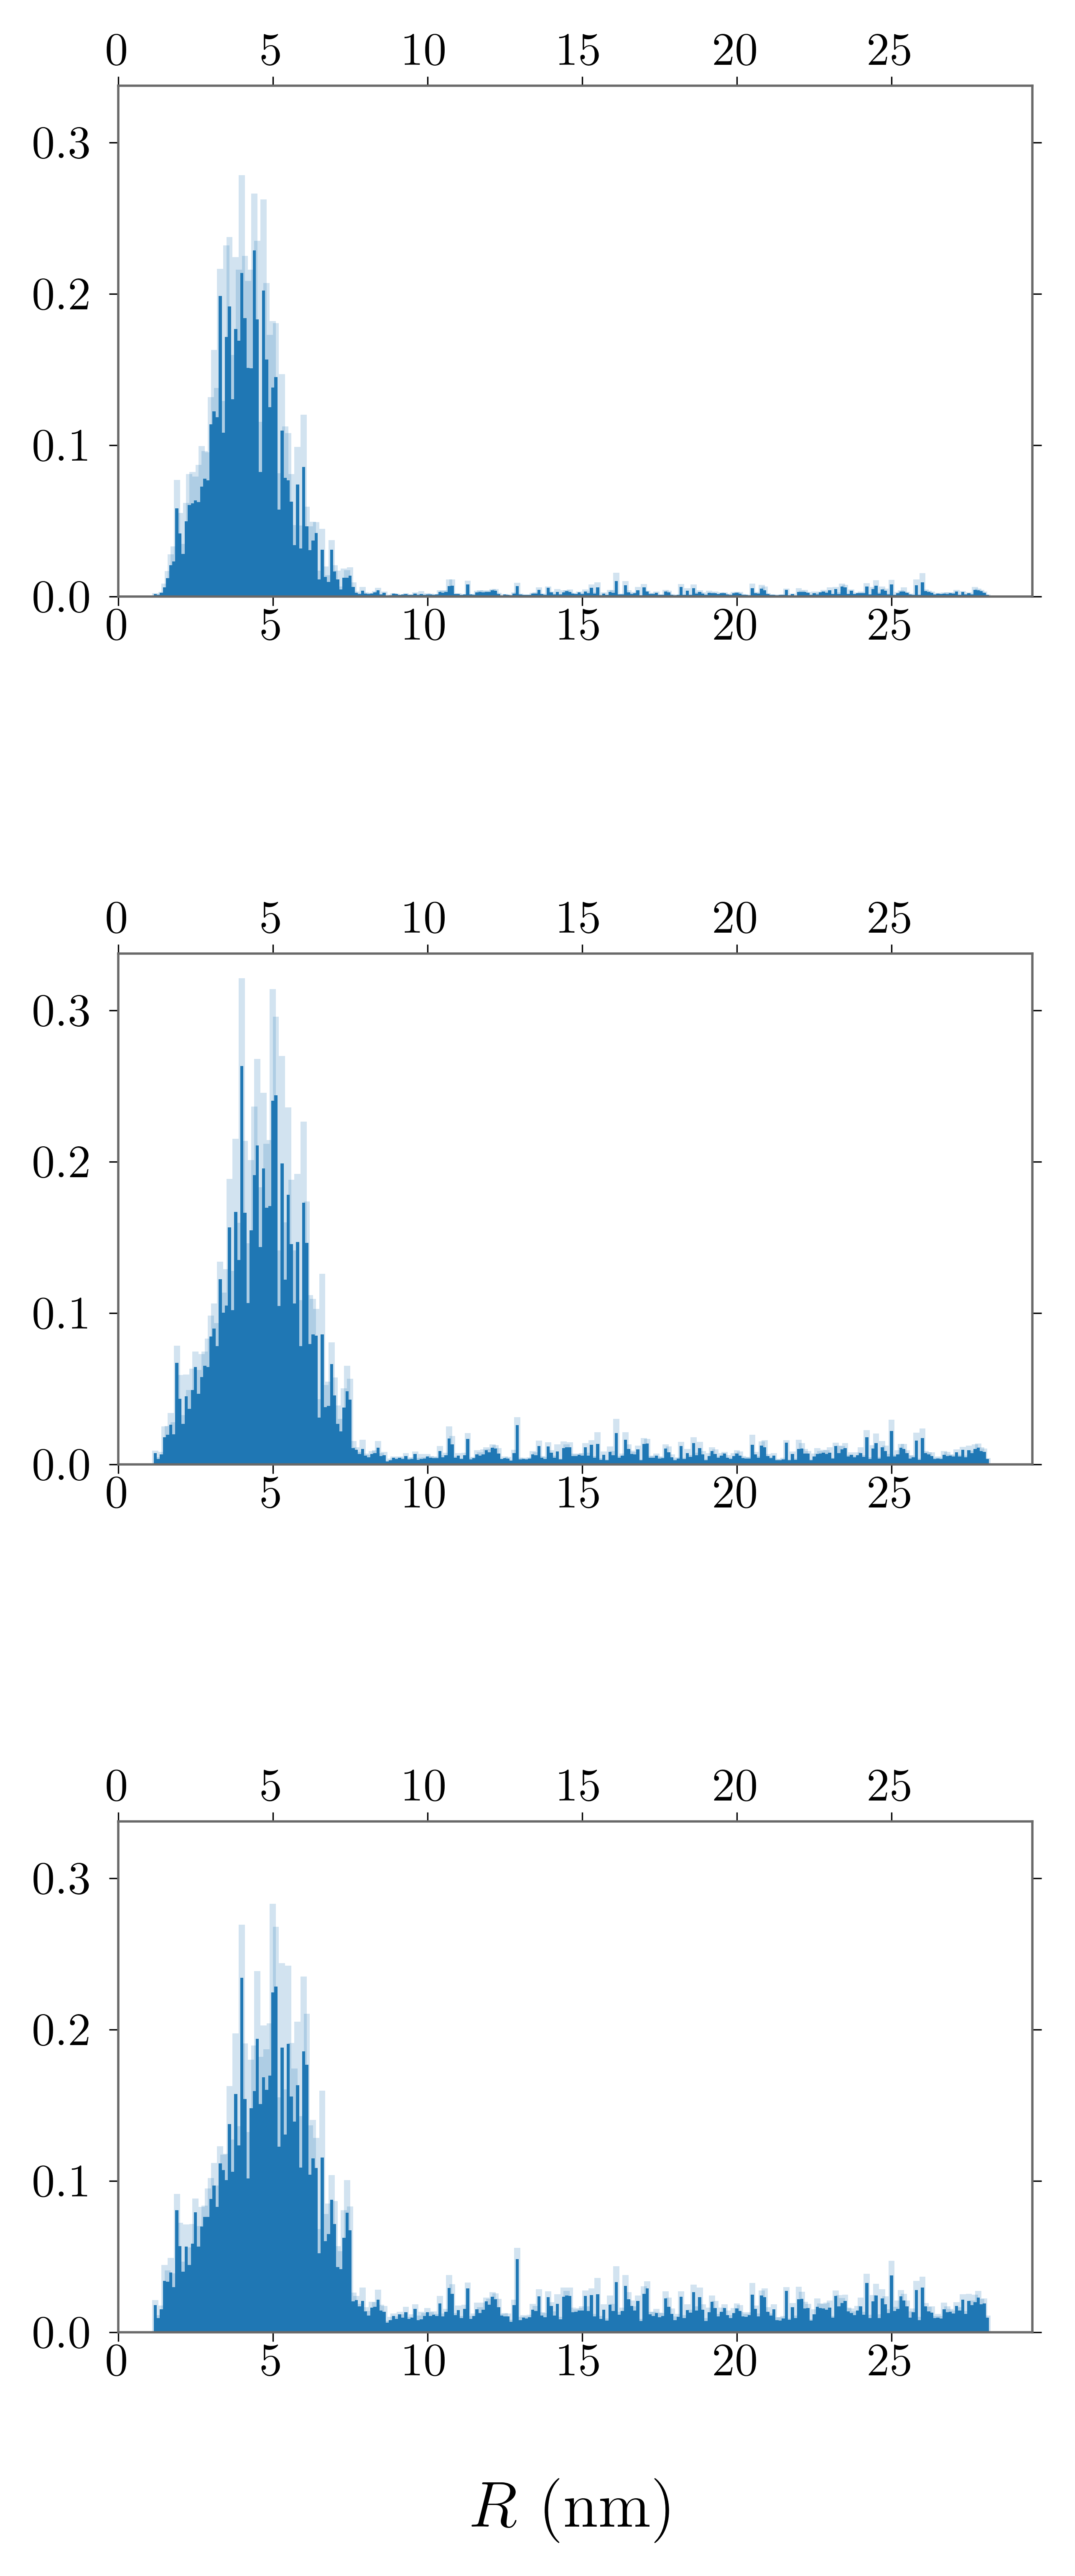

In [25]:
evaluation = Evaluation_PDF(mode='pt')
evaluation.plot_pdf_lognorm_average(fit='MLE', K='500', log_scalex=False, nrows=3,ncols=1,extended=True, save=False)

#f25 = np.load('/home/danshach/pot_store/gpfs_scratch/Xalantir/results/radius/mlp2/run_106/round_2/raw_labels_test_sputter_100K_data.npz')

      $\sigma^2$     $\mu$  weighted average  ground truth  expected value
0.98    0.972357  0.258954               2.6           2.5             2.1
1.01    0.975276  0.258576               2.6           2.6             2.1
1.04    0.976065  0.257839               2.6           2.6             2.1
1.07    0.976447  0.256857               2.6           2.7             2.1
1.10    0.981793  0.256806               2.7           2.7             2.1
...          ...       ...               ...           ...             ...
7.88    1.309284  0.502084              10.5          12.2             3.9
7.91    1.313281  0.518395              10.6          12.3             4.0
7.94    1.322010  0.545880              10.7          12.4             4.1
7.97    1.324095  0.552176              10.7          12.4             4.2
7.99    1.313521  0.515163              10.6          12.4             4.0

[243 rows x 5 columns]


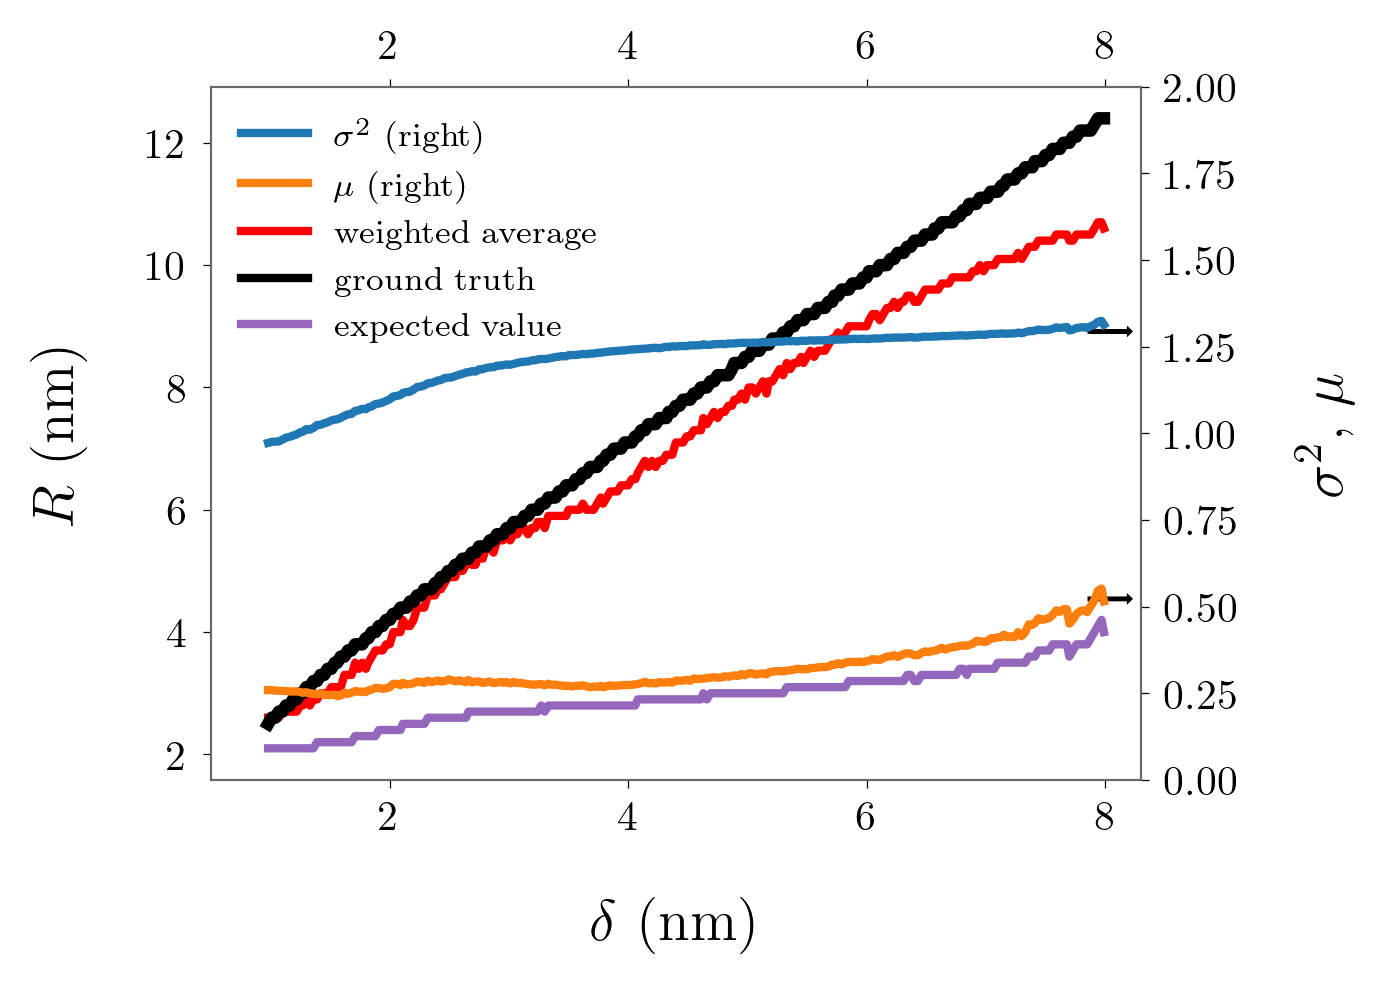

In [129]:
evaluation.plot_lognorm_parameter_curves(fit='NLS', K='500', log_scalex=False, extended=False, save=True)


In [ ]:
frames = evaluation.run.get_frames(K='400')
interval = frames[0].interval
gt = interval[frames[-1].ground_truth]
pred = interval[frames[-1].average_prediction]

In [ ]:
mu = np.log(pred)-(0.7**2/2)
lognorm_curve = frames[-1].get_lognorm_pdf_given_params(shape=0.7,location=mu)

In [ ]:
lab = frames[-1].get_average_label()
lab_sum = [sum(lab[i:i+10]) for i in range(0,len(lab),10)]
interval_sum = [sum(interval[i:i+10]) for i in range(0,len(interval),10)]

In [ ]:
from scipy.stats import norm
normc = norm.pdf(interval, loc=np.log(gt), scale=var)

In [ ]:
for frame in frames:
    fig = plt.subplots(figsize=(3, 2), dpi=300) # for paper
    #plt.plot(interval, lognorm_curve, 'r-', linewidth=2)
    #plt.plot(interval, normc, 'r-', linewidth=2)
    plt.bar(interval, frame.get_average_label(), width=0.2, color='#1f77b4')
    plt.xscale("log")
    plt.ylim((0,0.045))
    plt.title(r'$\delta=$ '+ str(frame.thickness) + ' nm')
    plt.show()

In [ ]:
np.exp(1.82+(0.67**2/2))